In [1]:
#mounted a space on your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#see the ls command to see the content of the repertory
!ls "/content/gdrive/My Drive/kaggle"

 kaggle.json		  'spaceship-titanic.zip (Unzipped Files)'
 spaceship_titanic.ipynb   use_colab_drive_Down_dataset.ipynb
 spaceship-titanic.zip	  'USE_CPU_GPU_TPU_on collab.ipynb'


In [3]:
#unzip the zip package download on kaggle
#!unzip gdrive/My\ Drive/kaggle/spaceship-titanic.zip

In [4]:
#import library
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

data= pd.concat([train,test], axis=0)
print("train:",train.shape,"test:",test.shape,"all data:",data.shape)
data.head(5)

train: (8693, 14) test: (4277, 13) all data: (12970, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
#check the empty  or Nan values in the dataset
data.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


There are a lot of missing values, try to correct that.



#Preprocess Data





In [7]:
#separate the passenger_id to have the group number
data[['group_num','passenger_num']] = data.PassengerId.str.split('_',expand=True,).astype(int)

#separate the cabin column to have 3 new columns with deck, num, side
data[['cabin_deck', 'cabin_num', 'cabin_side']] = data.Cabin.str.split('/',expand=True,)

In [8]:
# Replace categorical variables with specific values (False, None and  with the value before).
data['CryoSleep'].fillna(False, inplace=True)
data['VIP'].fillna(False, inplace=True)
data['HomePlanet'].fillna(data.HomePlanet.mode()[0], inplace=True)
data['Destination'].fillna(data.Destination.mode()[0], inplace=True)
data['Name'].fillna(data.Name.mode()[0], inplace=True)
data['cabin_deck'].fillna(data.cabin_deck.mode()[0], inplace=True)
data['cabin_deck'].astype("category")
data['cabin_num'].fillna(data.cabin_num.mode()[0], inplace=True)
data['cabin_num'].astype(int)
data['cabin_side'].fillna(data.cabin_side.mode()[0], inplace=True)
data['cabin_side'].astype("category")

#Replace numerical variables with mean and 0
data['Age'].fillna(data.Age.mean(), inplace=True)
data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

#create a total amount column for the  money spent used for the services
data['TotalSpend'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']

In [9]:
#delete PassengerId and Cabin 
df = data.drop(['Cabin','PassengerId'], axis=1)
df.isnull().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name                0
Transported      4277
group_num           0
passenger_num       0
cabin_deck          0
cabin_num           0
cabin_side          0
TotalSpend          0
dtype: int64

Cool there is no missing data


# Mutual information

In [10]:
X = df.copy()[:train.shape[0]]
y = X.pop("Transported")


# Label encoding for categoricals
for colname in X.select_dtypes("object"):
  X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [11]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

group_num        1.512075
cabin_num        0.445523
TotalSpend       0.129982
CryoSleep        0.113299
Name             0.085574
Spa              0.070979
RoomService      0.065576
VRDeck           0.054310
ShoppingMall     0.045121
FoodCourt        0.034708
HomePlanet       0.019951
cabin_side       0.015324
Age              0.013308
Destination      0.011297
cabin_deck       0.010995
VIP              0.007493
passenger_num    0.003262
Name: MI Scores, dtype: float64

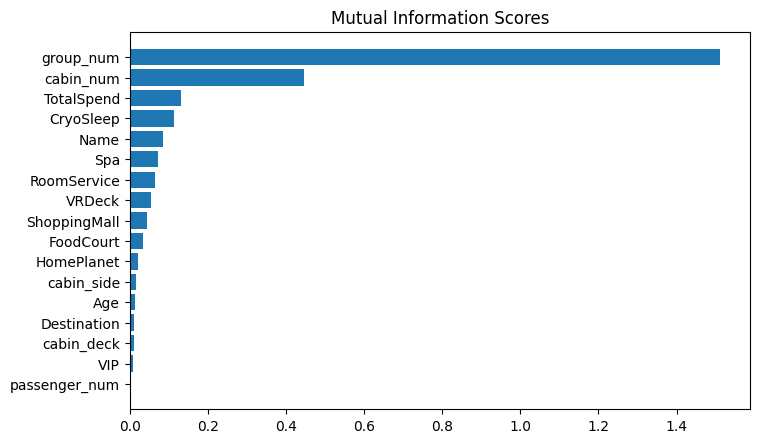

In [12]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

The mutual information inform us that group_num, cabin_num are not very good data for predicting the target

# Linear Correlation

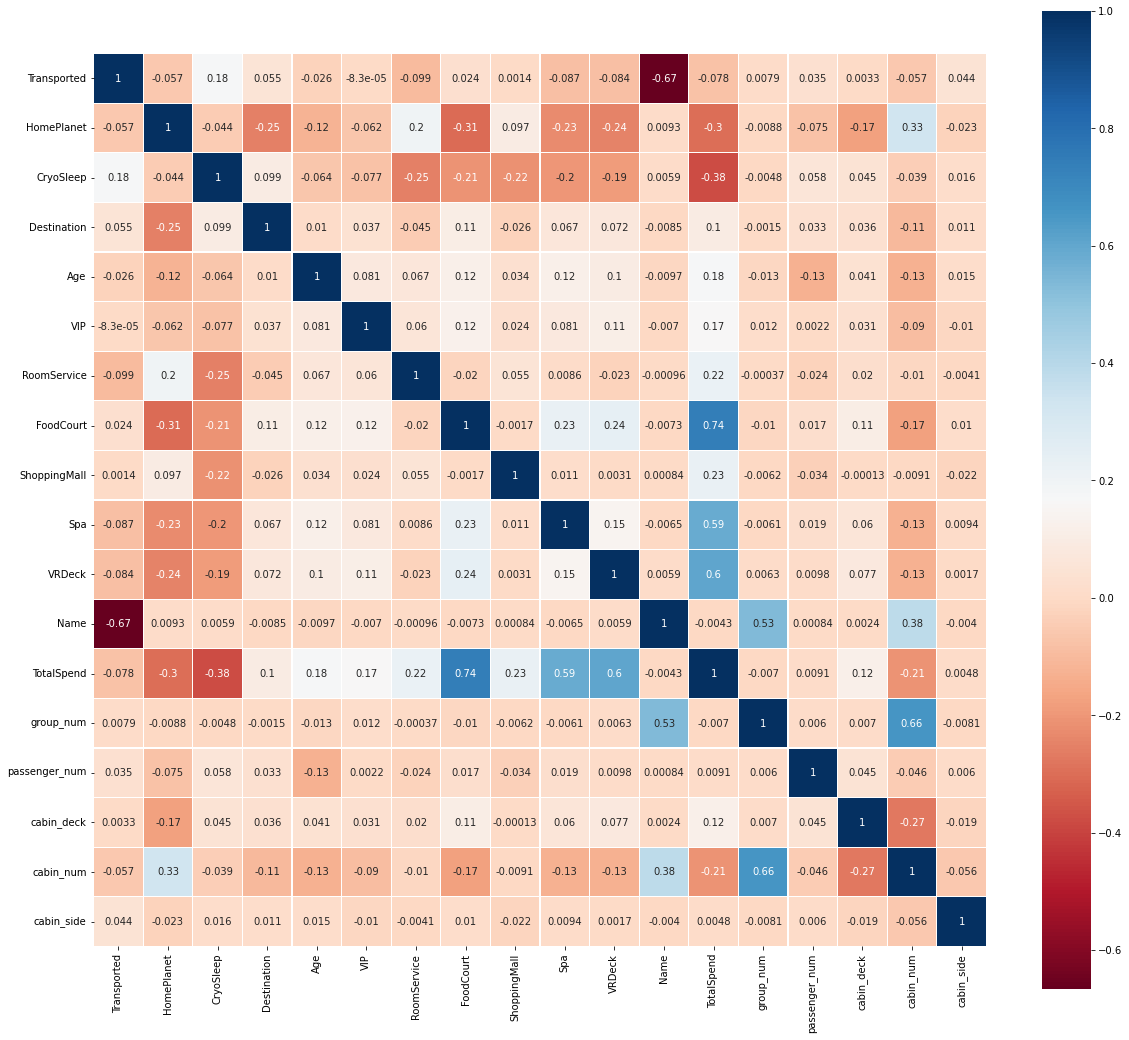

In [39]:
# Let's see with the linear correlation in factorizing the categoricals columns
core= df.copy()
# Label encoding for categoricals
for colname in core.select_dtypes("object"):
  core[colname], _ = core[colname].factorize()



features = core[[
    'Transported',
    'HomePlanet',
    'CryoSleep',
    'Destination',
    'Age',
    'VIP',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'Name',
    'TotalSpend',
    'group_num',
    'passenger_num',
    'cabin_deck',
    'cabin_num',
    'cabin_side'
]]
plt.figure(figsize=(20,18))
sns.heatmap(features.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=plt.cm.RdBu, annot=True)

Name is the variables not very well correlated with the target

# Train XGBoost model 

i decided to keep the columns object factorized to train the model

In [15]:
#Split Train /test
train_data, x_test = core.iloc[:train.shape[0]], core.iloc[train.shape[0]:].drop(['Transported'], axis=1)
x_train, y_train = train_data.drop(['Transported'], axis=1), train_data['Transported']
print("x_train:",x_train.shape, "y_train:",y_train.shape,"x_test:",x_test.shape)

x_train: (8693, 17) y_train: (8693,) x_test: (4277, 17)


In [30]:

#remove features with low correlation with the target 
trn_feat = [
            'CryoSleep',
      'Destination',
      'Age',
      #'VIP',
      'RoomService',
      'FoodCourt',
      'ShoppingMall',
      'Spa',
      'VRDeck',
      #'Name',
      'TotalSpend',
      #'group_num',
      'passenger_num',
      'cabin_deck',
      'cabin_num',
      'cabin_side'
]



model = XGBClassifier(booster="gbtree", colsample_bylevel=1,
       colsample_bytree=0.65, gamma=2, learning_rate=0.3, max_delta_step=1,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1 )



# Preprocessing of training data, fit model 
model.fit(x_train[trn_feat], y_train)

# Preprocessing of validation data, get predictions
preds = model.predict(x_test[trn_feat])



In [31]:
print(model.score(x_train[trn_feat], y_train))


0.8736914759001495


In [32]:
from sklearn import model_selection

scores = model_selection.cross_val_score(model, x_train[trn_feat], y_train, cv=6, scoring='accuracy')
print(scores)
print("Kfold on XGBClassifier: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

[0.77708765 0.76673568 0.76880607 0.81987578 0.82332643 0.78936464]
Kfold on XGBClassifier: 0.7909 (+/- 0.0229)


In [33]:
feature_importance = list(zip(x_train.columns.values, model.feature_importances_))
feature_importance.sort(key=lambda x:x[1])
feature_importance

[('VRDeck', 0.017835343),
 ('Destination', 0.023399381),
 ('group_num', 0.031642247),
 ('CryoSleep', 0.050989524),
 ('RoomService', 0.051003534),
 ('Age', 0.05282929),
 ('passenger_num', 0.056808818),
 ('ShoppingMall', 0.060428362),
 ('FoodCourt', 0.06487816),
 ('VIP', 0.0684061),
 ('Name', 0.09971062),
 ('Spa', 0.18540995),
 ('HomePlanet', 0.23665877)]

In [ ]:
#visualize the fetaures importances
plot_x = x_train[trn_feat]
pd.Series(model.feature_importances_, index = plot_x.columns).sort_values(ascending = True).plot(kind='barh')

In [34]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"], 
    "Survived": preds 
})

In [35]:
submission.to_csv('submission.csv', index=False)